In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [152]:
df = pd.read_csv('datasets/dataset_train.csv')[['Hogwarts House', 'Herbology', 'Defense Against the Dark Arts',
       'Divination', 'Muggle Studies', 'Ancient Runes', 'History of Magic',
       'Transfiguration', 'Care of Magical Creatures', 'Charms', 'Flying']]
df.head()

,Hogwarts House,Herbology,Defense Against the Dark Arts,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Care of Magical Creatures,Charms,Flying
0,Ravenclaw,5.727180,4.878861,4.722,272.035831,532.484226,5.231058,1039.788281,0.715939,-232.79405,-26.89
1,Slytherin,-5.987446,5.520605,-5.612,-487.340557,367.760303,4.107170,1058.944592,0.091674,-252.18425,-113.45
2,Ravenclaw,7.725017,3.660761,6.140,664.893521,602.585284,3.555579,1088.088348,-0.515327,-227.34265,30.42
3,Gryffindor,-6.497214,-6.977428,4.026,-537.001128,523.982133,-4.809637,920.391449,-0.014040,-256.84675,200.64
4,Gryffindor,-7.820623,NaN,2.236,-444.262537,599.324514,-3.444377,937.434724,-0.264070,-256.38730,157.98


In [153]:
# target = np.array(['Ravenclaw', 'Slytherin', 'Gryffindor'])
# df = df[['Hogwarts House', 'Muggle Studies', 'Charms', 'Divination', 'Flying', 'History of Magic', 'Transfiguration']]

target = np.array(['Ravenclaw', 'Slytherin', 'Gryffindor',
                    'Ravenclaw', 'Slytherin', 'Gryffindor'])
df1 = df[['Hogwarts House', 'Muggle Studies', 'Charms', 'Divination', 'Flying', 'History of Magic', 'Transfiguration']]
df2 = df[['Charms', 'Care of Magical Creatures']]
df2.columns = ['Charms2', 'Care of Magical Creatures2']
df3 = df[['Divination', 'Care of Magical Creatures']]
df3.columns = ['Divination3', 'Care of Magical Creatures3']
df4 = df[['Herbology', 'Flying']]
df4.columns = ['Herbology4', 'Flying4']
df = pd.concat([df1, df2, df3, df4], axis=1)

In [154]:
df.shape[0]

1600

In [155]:
df.shape[0] - df.dropna().shape[0]

215

In [156]:
df = df.dropna()

In [157]:
df.shape

(1385, 13)

In [158]:
# div = 0.9
# df_test = df.iloc[int(df.shape[0] * div):]
# df = df.iloc[:int(df.shape[0] * div)]
# df.shape

In [159]:
def get_minmax(x):
    x_minmax = np.zeros([x.shape[1], 2], np.float32)
    for i in range(x.shape[1]):
        x_minmax[i] = [x[:, i].min(), x[:, i].max()]
    return x_minmax

def normalization(target, val_min, val_max):
    return (target - val_min) / (val_max - val_min)

def set_xnorm(x, x_minmax):
    for i in range(x.shape[1]):
        x[:, i] = normalization(x[:, i], *x_minmax[i])

y = df.values[:, 0]
x = df.values[:, 1:].astype(np.float32)
x_minmax = get_minmax(x)
set_xnorm(x, x_minmax)
bias = np.ones((x.shape[0], 1))
x = np.concatenate((x, bias), 1)

In [160]:
def sigmoid(predict):
    sigmoid = 1 / (1 + np.exp(-predict))
    return sigmoid

def loss_log(predict, target):
    loss_log = -np.mean(target * np.log(predict) +
                        (1 - target) * np.log(1 - predict))
    return loss_log

def get_vecpredict(x, weight, i):
    predict = sigmoid(np.concatenate([x[:, (i * 2):(i * 2 + 2)],
                                        x[:, -1].reshape(-1, 1)],
                                        axis=1) @\
                        weight[(i * 3):(i * 3 + 3)])
    return predict

def get_bintarget(x, y, target):
    y_bin = np.zeros([target.size, y.size], np.int8)
    for i in range(y_bin.shape[0]):
        y_bin[i] = list(map(lambda x: 1 if x == target[i] else 0, y))
    return y_bin


def set_errorepoch(error, epoch, x, weight, y_bin, target):
    for i in range(target.size):
        error[epoch][i] = loss_log(get_vecpredict(x, weight, i), y_bin[i])



In [161]:
def predict_error(predict, y, i, target):
    error = predict - int(y[i] == target)
    return error

def sigmoid_derivative(predict):
    derivative = predict * (1 - predict)
    return derivative

def feature_slice(x, i, j):
    slc = np.concatenate([x[i][(j * 2):(j * 2 + 2)],
                        [x[i][-1]]])
    return slc

def get_housepredict(x, weight, i, j):
    predict = sigmoid(np.concatenate([x[i][(j * 2):(j * 2 + 2)],
                                    [1]]) @ weight[(j * 3):(j * 3 + 3)])
    return predict

def fill_delta(delta, x, weight, y, i, target):
    for j in range(target.size):
        predict = get_housepredict(x, weight, i, j)
        delta[(j * 3):(j * 3 + 3)] += predict_error(predict, y,
                                                    i, target[j]) *\
                                        sigmoid_derivative(predict) *\
                                        feature_slice(x, i, j)

def update_weight(weight, delta):
    weight -= delta * alpha
    delta[:] = 0
    return 0

def learning_nn(x, y, target, epochs, alpha, batch, eborder):
    weight = np.random.random(x.shape[1] + target.size - 1)
    delta = np.zeros(weight.size, np.float32)
    error = np.zeros([epochs, target.size], np.float32)
    y_bin = get_bintarget(x, y, target)
    # print(y_bin.shape)
    cursor = 0
    for epoch in range(epochs):
        set_errorepoch(error, epoch, x, weight, y_bin, target)        
        if np.all([i < eborder for i in error[epoch]]):
            return weight, error, epoch
        for i in range(x.shape[0]):
            fill_delta(delta, x, weight, y, i, target)
            cursor += 1
            if cursor == batch:
                cursor = update_weight(weight, delta)
        cursor = update_weight(weight, delta)
        np.random.shuffle([x, y])
    return weight, error, epoch

epochs = 300
alpha = 0.01
batch = 500
eborder = 0.12
weight, error, epoch = learning_nn(x, y, target, epochs, alpha, batch, eborder)


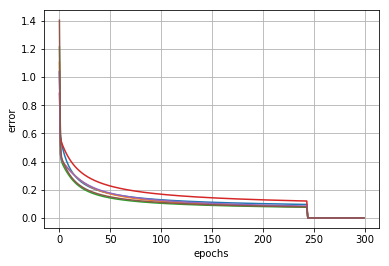

In [162]:
plt.plot(range(epochs), error)
plt.xlabel('epochs')
plt.ylabel('error')
plt.grid()
plt.show()

In [163]:
error[epoch]

array([0.09560572, 0.07894105, 0.07585808, 0.11993878, 0.08400959,
       0.07870205], dtype=float32)

In [164]:
weight

array([  6.21448266,   5.98802938,  -7.0926588 ,  -9.12873337,
        -2.40493783,   4.57346868,  -5.66285179,  -5.96861912,
         4.78213066,  10.82249658,  -0.88315811,  -6.75506808,
       -10.04241152,   0.83109178,   3.71438111,  -5.18462789,
         8.37029029,  -3.07951767])

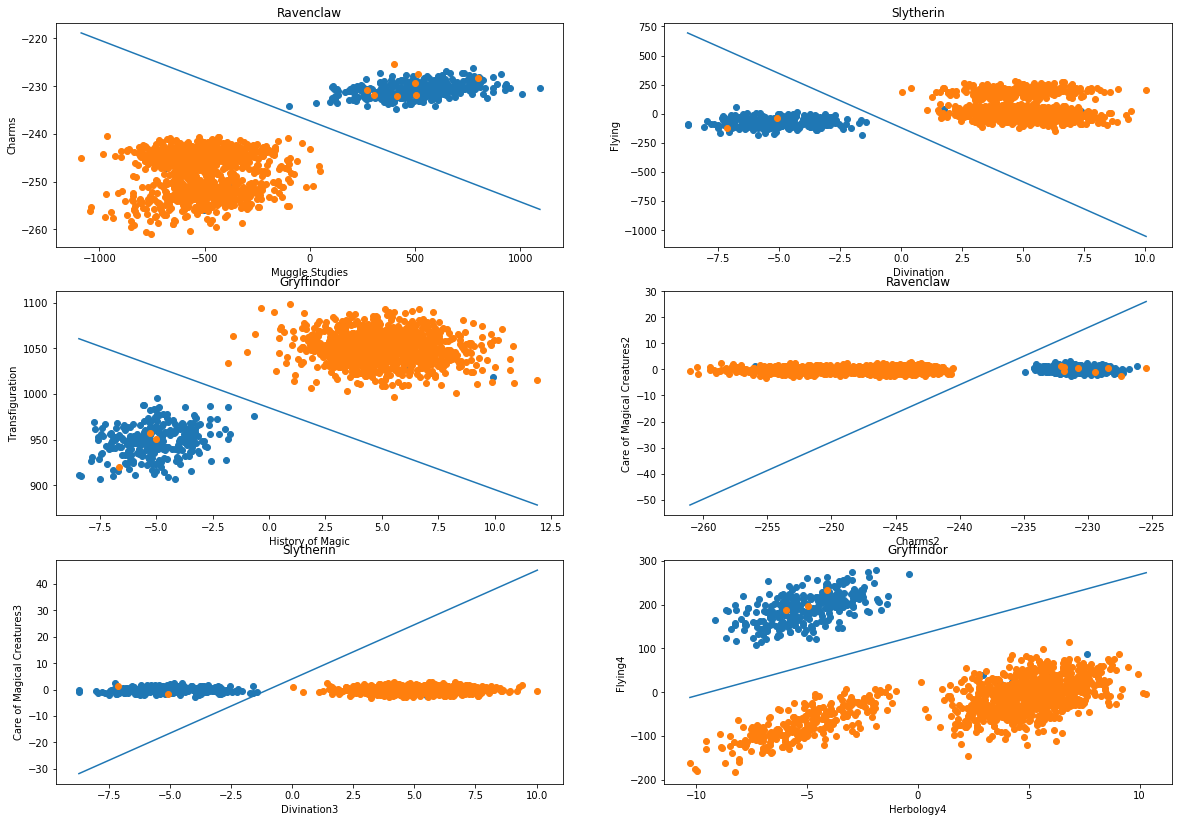

In [165]:

fig, axis = plt.subplots(target.size // 2 + int(bool(target.size % 2)), 2, figsize=(20, 14))
for i in range(target.size):
    axis[i // 2, i % 2].scatter(df[df['Hogwarts House'] ==\
        target[i]][df.columns[2 * i + 1]],
        df[df['Hogwarts House'] ==\
        target[i]][df.columns[2 * i + 2]])
    axis[i // 2, i % 2].scatter(df[df['Hogwarts House'] !=\
        target[i]][df.columns[2 * i + 1]],
        df[df['Hogwarts House'] !=\
        target[i]][df.columns[2 * i + 2]])
    divider_x0 = x_minmax[i * 2]
    divider_x1 = -(normalization(x_minmax[i * 2],
                                *x_minmax[i * 2]) *\
                    weight[i * 3] + weight[i * 3 + 2]) /\
                weight[i * 3 + 1]
    divider_x1 = divider_x1 *\
                (x_minmax[i * 2 + 1][1] - x_minmax[i * 2 + 1][0]) +\
                x_minmax[i * 2 + 1][0]
    axis[i // 2, i % 2].plot(divider_x0, divider_x1)
    axis[i // 2, i % 2].set(title=target[i], xlabel=df.columns[i * 2 + 1], ylabel=df.columns[i * 2 + 2])


plt.show()

In [166]:
# df_test = pd.read_csv('datasets/dataset_test.csv')
# df_test = df_test[['Hogwarts House', 'Muggle Studies', 'Charms', 'Divination', 'Flying', 'History of Magic', 'Transfiguration']]

df_test = pd.read_csv('datasets/dataset_test.csv')
df_test1 = df_test[['Hogwarts House', 'Muggle Studies', 'Charms', 'Divination', 'Flying', 'History of Magic', 'Transfiguration']]
df_test2 = df_test[['Charms', 'Care of Magical Creatures']]
df_test2.columns = ['Charms2', 'Care of Magical Creatures2']
df_test3 = df_test[['Divination', 'Care of Magical Creatures']]
df_test3.columns = ['Divination3', 'Care of Magical Creatures3']
df_test4 = df_test[['Herbology', 'Flying']]
df_test4.columns = ['Herbology4', 'Flying4']
df_test = pd.concat([df_test1, df_test2, df_test3, df_test4], axis=1)


df_test.head()

,Hogwarts House,Muggle Studies,Charms,Divination,Flying,History of Magic,Transfiguration,Charms2,Care of Magical Creatures2,Divination3,Care of Magical Creatures3,Herbology4,Flying4
0,NaN,-365.151850,-244.48172,7.996,-13.62,4.207691,1046.742736,-244.48172,0.373853,7.996,0.373853,3.020172,-13.62
1,NaN,522.580486,-231.29200,6.349,-26.26,6.460017,1048.053878,-231.29200,0.577432,6.349,0.577432,2.965226,-26.26
2,NaN,-630.073207,-252.99343,4.619,200.15,-5.565818,936.437358,-252.99343,-1.647150,4.619,-1.647150,-6.185697,200.15
3,NaN,-449.179806,-244.01660,NaN,-11.15,NaN,1043.397718,-244.01660,1.164708,NaN,1.164708,4.962442,-11.15
4,NaN,-449.732166,-243.99806,4.886,-7.12,2.876347,1051.377936,-243.99806,0.102104,4.886,0.102104,3.737656,-7.12


In [167]:
count = 0
probability = np.zeros(target.size, np.float32)
for i in range(df_test.shape[0]):
    instance = df_test.iloc[i].values[1:].astype(np.float32)
    for j in range(instance.size):
        instance[j] = normalization(instance[j], *x_minmax[j])
    for i in range(probability.size):
        probability[i] =\
            sigmoid(np.concatenate([instance[(i * 2):(i * 2 + 2)], [1]]) @\
                                    weight[(i * 3):(i * 3 + 3)])
            
        # if np.isnan(probability[i]):
        #     probability[i] = 0
    # print(probability)
    # print(np.max(probability))

    if np.max(probability) > 0.5:
        # print(probability)
        house = target[np.where(probability == np.max(probability))[0][0]]
    else:
        if np.all([i < 0.5 for i in probability]):
            house = 'Hufflepuff'
            # print(probability)
        else:
            # print(probability)
            house = 'nan'

    # print(house)
    if house == 'nan':
        count += 1

print(count, 100 - count / df_test.shape[0] * 100)

52 87.0
